## Problem Statement


FashionKart allows consumers to buy latest products from e-commerce platforms. Customers can leave reviews of products and experience to help other users make their purchase choices.
 
Given the dataset of product reviews and recommendation status, build a text classification model that can correctly identify the users who will recommend the product in the future. Also provide key topics/themes emerging from the customer reviews along with visualisation charts.

**Review:** Customer review for the product

**Recommendation:** Customer's recommendation for the product 

## Table of Content

1. **[Import Libraries](#lib)**
2. **[Load the Data](#data)**
3. **[Data Exploration](#eda)**
4. **[Data Preperation](#prep)**
5. **[Data Split](#split)**
6. **[Machine Learning Modeling](#model)**
    - 6.1 - **[Count vectorizer](#cv)**
    - 6.2 - **[TF-IDF](#tfidf)**
7. **[Topic Modelling ](#topic)**
    - 7.1 - **[Topic Visualization](#vis)**

<a id="lib"></a>
### Step 1 : Load required libraries 

In [1]:
pip install umap

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pyLDAvis

Note: you may need to restart the kernel to use updated packages.


In [3]:
#import the libraries
import numpy as np
import pandas as pd
import os
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
import umap
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score
from nltk import sent_tokenize, word_tokenize
import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
     
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AravindDudipala\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AravindDudipala\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\AravindDudipala\anaconda3\lib\site-packages\seaborn\rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\AravindDudipala\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


<a id="data"></a>
### Step 2 : Load the input data 

In [4]:
#read the input data
input_data = pd.read_csv('dataset.csv')
#scan the dataframe
input_data.head()

,Review,Recommend
0,Absolutely wonderful - silky and sexy and comf...,1
1,Love this dress! it's sooo pretty. i happene...,1
2,I had such high hopes for this dress and reall...,0
3,"I love, love, love this jumpsuit. it's fun, fl...",1
4,This shirt is very flattering to all due to th...,1


In [5]:
#convert the object datatype type to string
input_data.info()
input_data['Review']=input_data['Review'].astype('str') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     22641 non-null  object
 1   Recommend  23486 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 367.1+ KB


In [6]:
#check the size of the dataframe
input_data.shape

(23486, 2)

In [7]:
#check the target class distribution in the dataset
input_data['Recommend'].value_counts()

1    19314
0     4172
Name: Recommend, dtype: int64

As we can see there are around 23K+ reviews in the dataset. Each review has a corresponding recommendation value and there are more recommended products compared to non-recommended

<a id="eda"></a>
### Step 3 : Explore the data 

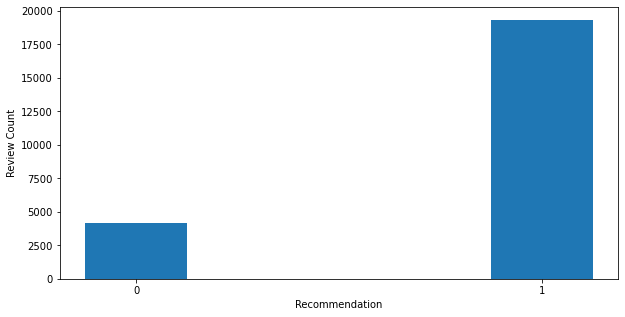

In [8]:
#check for the target class counts 
label_dist = input_data['Recommend'].value_counts().to_dict()
fig = plt.figure(figsize = (10, 5))
ax = plt.bar(label_dist.keys(), label_dist.values(), width=0.25)
plt.xticks([0,1])
plt.xlabel("Recommendation")
plt.ylabel("Review Count")
plt.show()

In [9]:
#check for any empty rows 
print(input_data.isnull().sum())

Review       0
Recommend    0
dtype: int64


In [10]:
#check for any duplicate reviews 
len(input_data['Review'])-len(input_data['Review'].drop_duplicates())


851

As we can observe there are 851 reviews which seem to be duplicate values. We will drop these from the dataframe.

In [11]:
#drop the repeated reviews 
input_data=input_data.drop_duplicates(subset='Review', keep="last")
input_data.shape

(22635, 2)

We can now check the size of each review to establish if there is any relation between the recommendation and length of the reviews 

In [12]:
#check for the length of reviews 
input_data['length']=input_data['Review'].apply(lambda x: len(x.split(' ')))

In [13]:
#validate the newly added column in the dataframe 
input_data.sample(10)

,Review,Recommend,length
10072,Love this top! i bought it in 2 colors; it's a...,1,20
19589,This top is very pretty and looks so good with...,1,106
19585,These pants are beautiful. the color is a nice...,1,95
17815,I didn't pay much attention to this shirt on t...,1,88
15179,"Other than the color (i got the rose color), w...",1,78
20734,I'm so excited that retailer is bringing back ...,1,82
6588,Love this top!!!! it is just gorgeous and fits...,1,10
21293,Love these pants- they are so soft and comfort...,1,44
12766,"I am a 5'10"" size 4 (or 28 long - i need a 33-...",1,86
12428,"I love this top (so cute and comfy!), but i wo...",0,61


In [14]:
#avg. length for recommended and non recommended review 
print(round(input_data[input_data['Recommend']== 1 ]['length'].mean()))
print(round(input_data[input_data['Recommend']== 0]['length'].mean()))

60
62


Seems like there isn't much of a difference between size of the customer review in the dataset 

<a id="prep"></a>
### Step 4 : Data Preperation

Since the reviews are raw texts and contains multiple symbols, punctuations , hastags which might not be very useful for the modeling . 
We will use a helper function to clean the text and prepare it for modeling purpose.

In [15]:
# helper function to remove stopwords
input_data["Review_new"]=input_data["Review"].apply(lambda x: ' '.join([word for word in x.split() if word not in (STOPWORDS)]))

In [16]:
#helper function for review cleaning 
def text_clean(review):
    #lowercase the review
    review=review.lower()
    #remove punctuation 
    review = re.sub('[()!?]', ' ', review)
    review = re.sub('\[.*?\]',' ', review)
    #remove non alphanumeric occurences
    review = re.sub("[^a-z0-9]"," ", review)
    #remove the @mention
    review = re.sub("@[A-Za-z0-9_]+","", review)
    #remove the hastags
    review = re.sub("#[A-Za-z0-9_]+","", review)
    #remove any links 
    review = re.sub(r"http\S+", "", review)
    review = re.sub(r"www.\S+", "", review)
    return review

In [17]:
#apply the function on the review column 
input_data['clean_review'] = input_data['Review_new'].apply(text_clean)

In [18]:
#validate if the reviews are clean
input_data[['Review','clean_review']].sample(10)

,Review,clean_review
9956,I just received these jeans and the fit it goo...,i received jeans fit good smell like moth bal...
21040,"When i wore this the two times i did, i got a ...",when wore two times did got ton compliments ...
18480,"And the bottom looks like a tutu. first, i hav...",and bottom looks like tutu first high tolera...
7930,I really like this top. while it looks somewha...,i really like top looks somewhat like t shirt...
1977,I agree with the other reviews - runs small. w...,i agree reviews runs small would perfect ac...
11928,This is a stylish blouse with classic features...,this stylish blouse classic features well quir...
2025,This dress runs large so i sized down. when it...,this dress runs large sized down arrived look...
21431,Cute shirt but it is very hard to wrap my head...,cute shirt hard wrap head around xxs sizing r...
19840,"I was so excited to wear this shirt, even afte...",i excited wear shirt even reading review curl...
14006,I had to order on line -- so popular that my s...,i order line popular store sold out ordere...


We can now observe that each review looks much cleaner and neat post the data cleansing prcoess 

In [19]:
# alculate updated length after removing the stopwords and cleaning review
input_data['new_length']=input_data['clean_review'].apply(lambda x: len(x.split(" ")))

In [20]:
#avg. length of the review for recommended and non-recommended labels 
print(round(input_data[input_data['Recommend']== 1]['new_length'].mean()))
print(round(input_data[input_data['Recommend']== 0]['new_length'].mean()))


41
41


Post the data cleaning, the avg. length of the review becomes the same 

<a id="split"></a>
### Step 5 : Data split 

Now we split the 23K+ data into training and test dataset. One thing to note is to split the data based on target class to maintain the class balance

In [21]:
#Sentiment Classifier
#split the data into training and test set with balanced split based on target class
X_train, X_test, y_train, y_test = train_test_split(input_data["clean_review"],
                                                    input_data["Recommend"],test_size=0.3,
                                                    stratify=input_data['Recommend'])

In [22]:
#check the shape of train and test data 
print(X_train.shape[0],X_test.shape[0])

15844 6791


In [23]:
#check the class balance in train data 
print(y_train.value_counts())

1    12974
0     2870
Name: Recommend, dtype: int64


In [24]:
#check the target class balance in test data 
print(y_test.value_counts())

1    5561
0    1230
Name: Recommend, dtype: int64


<a id="model"></a>
### Step 6  : ML Modeling and Performance evaluation

After splitting the data , we move on to the modelling part. Given we are doing text classification, we will convert the text data using two approaches :
1. Count Vectoriser 
2. TF-IDF 


<a id="cv"></a>
#### Using Count vectorizer

In [25]:
#Build a list of models to be trained and tested
modelclasses = [
    ["Logistic Regression", LogisticRegression],
    ["MNB", MultinomialNB],
    ["Random Forest", RandomForestClassifier]]

In [26]:
#Use the count vectoriser to convert the text data to numerical form
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

#create an empty dataframe to log performance of the model based on score and auc
results = pd.DataFrame(columns = ['modelname','score','auc'])

for modelname, Model in modelclasses:
    model = Model()
    model.fit(X_train_vec, y_train)
    score = np.round(model.score(X_test_vec, y_test),2)
    auc=np.round(roc_auc_score(y_test, model.predict_proba(X_test_vec)[:, 1]),2)
    results = results.append({'modelname' : modelname, 'score' : score,'auc':auc},
        ignore_index = True)


In [27]:
# Model performance 
results

,modelname,score,auc
0,Logistic Regression,0.88,0.91
1,MNB,0.89,0.92
2,Random Forest,0.85,0.91


As we can observe , the Multinomial Naive Baysian performs the best out of all the models using count vectoriser 

<a id="tfidf"></a>
#### Using TF-IDF

In [28]:
#Use the tf-idf vectoriser to convert the text data to numerical form
vectorizertfidf = TfidfVectorizer(token_pattern=r'\b\w+\b')
X_train_vec = vectorizertfidf.fit_transform(X_train)
X_test_vec = vectorizertfidf.transform(X_test)
results_tf = pd.DataFrame(columns = ['modelname','score','auc'])
for modelname, Model in modelclasses:
    model = Model()
    model.fit(X_train_vec, y_train)
    score = np.round(model.score(X_test_vec, y_test),2)
    auc=np.round(roc_auc_score(y_test, model.predict_proba(X_test_vec)[:, 1]),2)
    results_tf = results_tf.append({'modelname' : modelname, 'score' : score,'auc':auc},
        ignore_index = True)


In [29]:
#model comparison 
results_tf

,modelname,score,auc
0,Logistic Regression,0.88,0.93
1,MNB,0.82,0.90
2,Random Forest,0.85,0.91


Using the tf-idf vectoriser, we observe Logistic Regression outperforming the other models in terms of accuracy and auc.

<a id="topic"></a>
## Step 7 : Topic Modeling 

In [30]:
#add additonal data clearning
def topic_clean(review):
        #remove numeric & special characters occurences
        review = re.sub('[^a-zA-Z]', ' ', review)
        review = re.sub(r's+', ' ', review)
        return review

In [31]:
#apply the function on the review column 
input_data['clean_review'] = input_data['clean_review'].apply(topic_clean)

In [32]:
# Extract every unique term from the reviews 
review_terms = pd.Series(input_data['clean_review']).apply(lambda x: x.split())

In [33]:
# Create the disctioanry consisting index and unique term
dictionary = corpora.Dictionary(review_terms)

In [34]:
# Preapre the DTM(Document Term Matrix) from the term dictionary 
doc_term_matrix = [dictionary.doc2bow(rev) for rev in review_terms]

In [35]:
# Build the LDA model for topic extraction 
LDA = gensim.models.ldamodel.LdaModel
lda_model = LDA(corpus=doc_term_matrix,
                id2word=dictionary,
                num_topics=10, 
                chunksize=500,
                passes=10)
    

In [36]:
#print the top 10 topics 
lda_model.print_topics()


[(0,
  '0.042*"great" + 0.038*"love" + 0.029*"top" + 0.027*"hirt" + 0.026*"color" + 0.024*"fit" + 0.019*"i" + 0.019*"ual" + 0.018*"perfect" + 0.018*"oft"'),
 (1,
  '0.045*"wa" + 0.033*"e" + 0.025*"purcha" + 0.024*"ed" + 0.020*"ion" + 0.019*"hed" + 0.018*"one" + 0.017*"h" + 0.015*"t" + 0.013*"ye"'),
 (2,
  '0.031*"top" + 0.023*"like" + 0.022*"look" + 0.020*"fabric" + 0.018*"de" + 0.016*"e" + 0.014*"o" + 0.013*"back" + 0.012*"ign" + 0.012*"hirt"'),
 (3,
  '0.121*"color" + 0.076*"blue" + 0.037*"green" + 0.033*"grey" + 0.025*"gray" + 0.022*"pink" + 0.022*"kin" + 0.020*"navy" + 0.019*"orange" + 0.017*"vibrant"'),
 (4,
  '0.023*"tic" + 0.023*"clo" + 0.017*"h" + 0.016*"ela" + 0.014*"in" + 0.013*"pocket" + 0.013*"button" + 0.012*"et" + 0.011*"ide" + 0.011*"t"'),
 (5,
  '0.228*"dre" + 0.025*"ea" + 0.021*"y" + 0.020*"flattering" + 0.019*"fit" + 0.018*"thi" + 0.018*"perfect" + 0.017*"love" + 0.015*"wear" + 0.013*"kirt"'),
 (6,
  '0.042*"i" + 0.038*"ize" + 0.025*"t" + 0.024*"fit" + 0.023*"m" + 0.0

<a id="vis"></a>
#### Topic Visualization 

In [37]:
# Visualize the topics
pyLDAvis.enable_notebook()
# feed the LDA model into the pyLDAvis instance
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)     
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.146363 -0.080212       1        1  29.036331
2     -0.135239 -0.006553       2        1  16.365083
9     -0.004485 -0.136106       3        1  12.486443
7     -0.129214 -0.022651       4        1   9.458354
0     -0.138856  0.119845       5        1   9.004510
5     -0.141472  0.119119       6        1   7.537778
8     -0.047026  0.059019       7        1   5.916363
4      0.206433 -0.190527       8        1   3.827727
1      0.223787 -0.183877       9        1   3.819927
3      0.312434  0.321941      10        1   2.547484, topic_info=         Term          Freq         Total Category  logprob  loglift
9         dre  13085.000000  13085.000000  Default  30.0000  30.0000
105     color   7064.000000   7064.000000  Default  29.0000  29.0000
478    weater   2964.000000   2964.000000  Default  28.0000  28.0000
51        ize   9637.000000   9637.000000  Default  27.0000  27.0000
67        top   8587.000000   8587.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
188     light    216.568224   1370.649506  Topic10  -4.4968   1.8249
437  pictured    156.629839    468.702719  Topic10  -4.8208   2.5740
26    ordered    216.540190   3613.558515  Topic10  -4.4969   0.8554
584     photo    157.754900   1016.611110  Topic10  -4.8137   1.8069
245      fall    139.314008   1409.894062  Topic10  -4.9380   1.3555

[610 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         7  0.998797        ab
1533      5  0.996298  addition
88        9  0.997171      adju
2168      9  0.996884     adore
2390      4  0.996421        ag
...     ...       ...       ...
237       9  0.473291      year
1470     10  0.995009    yellow
74        1  0.203419    zipper
74        3  0.404264    zipper
74        8  0.391389    zipper

[1031 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 3, 10, 8, 1, 6, 9, 5, 2, 4])